# ResNets

The ResNet (*residual network*) was introduced in 2015 by Kaiming He et al in the article ["Deep Residual Learning for Image Recognition"](https://arxiv.org/abs/1512.03385).

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
from torch.nn import init
import torchvision.transforms.functional as TF
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

from fastprogress import progress_bar,master_bar

In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
xmean,xstd = 0.28,0.35
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

bs = 1024
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

  0%|          | 0/2 [00:00<?, ?it/s]

## Skip Connections

<img width="700" src="images/att_00042.png">

In [ ]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)

In [ ]:
def _conv_block(ni,nf,stride, act=act_gr):
    return nn.Sequential(
        conv(ni, nf, stride=stride, act=act),
        conv(nf, nf, act=None))

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, act=act_gr):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride, act=act)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, act=None)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return F.relu(self.convs(x) + self.idconv(self.pool(x)))

In [ ]:
def get_model(act=act_gr, nfs=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [ResBlock(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None), nn.Flatten()).to(def_device)

In [ ]:
model = get_model().apply(init_weights)

In [ ]:
lrf_cbs = [DeviceCB(), ProgressCB(), LRFinderCB()]
learn = MomentumLearner(model, dls, F.cross_entropy, lr=1e-5, cbs=lrf_cbs)

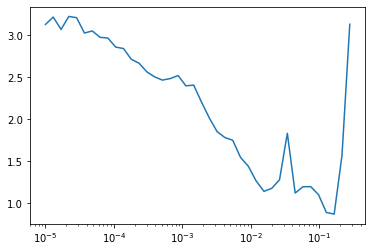

In [ ]:
learn.fit(1)

In [ ]:
set_seed(42)
iw = partial(init_weights, leaky=0.1)

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]

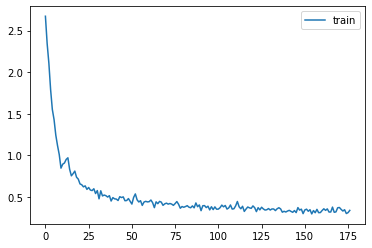

In [ ]:
model = get_model().apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.05, cbs=cbs)
learn.fit(3)

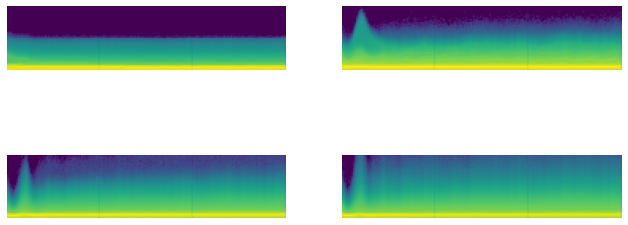

In [ ]:
astats.color_dim()

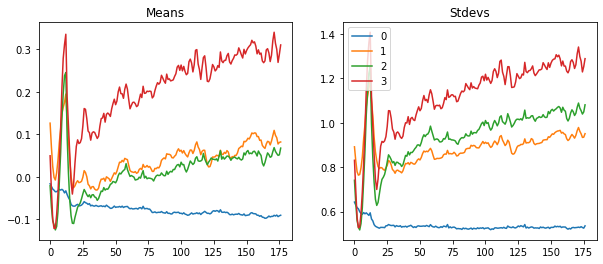

In [ ]:
astats.plot_stats()

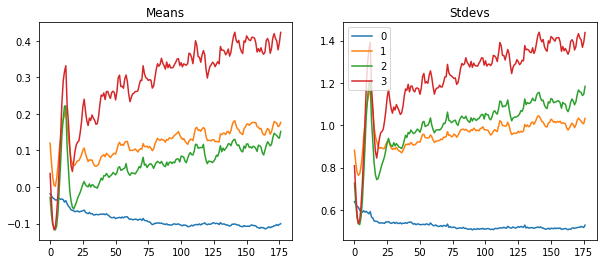

In [ ]:
astats.plot_stats()

### Bottleneck Layers

In [ ]:
def _conv_block(ni,nf,stride):
    return nn.Sequential(
        ConvLayer(ni, nf//4, 1),
        ConvLayer(nf//4, nf//4, stride=stride), 
        ConvLayer(nf//4, nf, 1, act_cls=None, norm_type=NormType.BatchZero))

In [ ]:
rn = ResNet(dls.c, [3,4,6,3], 4)

In [ ]:
learn = get_learner(rn)
learn.fit_one_cycle(20, 3e-3)

## Conclusion

## Questionnaire

1. How did we get to a single vector of activations in the CNNs used for MNIST in previous chapters? Why isn't that suitable for Imagenette?
1. What do we do for Imagenette instead?
1. What is "adaptive pooling"?
1. What is "average pooling"?
1. Why do we need `Flatten` after an adaptive average pooling layer?
1. What is a "skip connection"?
1. Why do skip connections allow us to train deeper models?
1. What does <<resnet_depth>> show? How did that lead to the idea of skip connections?
1. What is "identity mapping"?
1. What is the basic equation for a ResNet block (ignoring batchnorm and ReLU layers)?
1. What do ResNets have to do with residuals?
1. How do we deal with the skip connection when there is a stride-2 convolution? How about when the number of filters changes?
1. How can we express a 1×1 convolution in terms of a vector dot product?
1. Create a `1x1 convolution` with `F.conv2d` or `nn.Conv2d` and apply it to an image. What happens to the `shape` of the image?
1. What does the `noop` function return?
1. Explain what is shown in <<resnet_surface>>.
1. When is top-5 accuracy a better metric than top-1 accuracy?
1. What is the "stem" of a CNN?
1. Why do we use plain convolutions in the CNN stem, instead of ResNet blocks?
1. How does a bottleneck block differ from a plain ResNet block?
1. Why is a bottleneck block faster?
1. How do fully convolutional nets (and nets with adaptive pooling in general) allow for progressive resizing?

### Further Research

1. Try creating a fully convolutional net with adaptive average pooling for MNIST (note that you'll need fewer stride-2 layers). How does it compare to a network without such a pooling layer?
1. In <<chapter_foundations>> we introduce *Einstein summation notation*. Skip ahead to see how this works, and then write an implementation of the 1×1 convolution operation using `torch.einsum`. Compare it to the same operation using `torch.conv2d`.
1. Write a "top-5 accuracy" function using plain PyTorch or plain Python.
1. Train a model on Imagenette for more epochs, with and without label smoothing. Take a look at the Imagenette leaderboards and see how close you can get to the best results shown. Read the linked pages describing the leading approaches.